# <i>COM-418 - Computers and Music</i> <br /> <br />  <b>Nonlinear modelling</b> 

<div align="right"><a href="https://people.epfl.ch/lucie.perrotta">Lucie Perrotta</a> and <a href="https://people.epfl.ch/paolo.prandoni">Paolo Prandoni</a>, <a href="https://www.epfl.ch/labs/lcav/">LCAV, EPFL</a></div>

In [1]:
%matplotlib inline
import ipywidgets as widgets
import numpy as np
from numpy.fft import fft, ifft, hfft
from scipy.signal import lfilter, chirp
import matplotlib
import matplotlib.pyplot as plt
import math
from IPython.display import Audio
import import_ipynb
from Helpers import *

matplotlib.rcParams.update({'font.size': 16})
figsize=(10,5)

importing Jupyter notebook from Helpers.ipynb


In this notebook, we will review and implement a couple techniques for modelling nonlinear effects in music. Nonlinearities are omnipresent in music, like in amplifiers, distortions, and such. 

## 1. Static waveshaper

The simplest way to implement a nonlinearity digitally is to define a non-linear function in $[-1, 1] \rightarrow [-1, 1]$ and to apply it piece-wise to all samples of a signal. This method is called the **static waveshaper**, it does not depend on time and has no memory. To start, let's implement the nonlinear distortion function

\begin{align*}
    f_\alpha(x) = \frac{2}{\pi} \arctan ( \alpha \cdot x ) .
\end{align*}

While increasing the power of the low amplitudes, it reduces the range of the high amplitudes. It can be tuned by a parameter $\alpha$ that controls the intensity of the distortion: the higher $\alpha$ the harder the clipping.

In [3]:
def nonLinearFunction(x, alpha=20):
    """
    Static non-linearity between -1 and 1. One can choose among 3 non-linear functions by uncommenting one line.
    x: input signal
    a: order (intensity) of the non-linearity
    return: the filtered signal
    """
    # return 3*x/2 * (1- x**2 /3) # Distorsion proposed by Araya(1996)
    # return (np.abs(2*x) - x**2) * np.sign(x) # Distorsion proposed by Diodic(1998)
    return 2/np.pi * np.arctan(alpha*x) # Hard clipping distortion

One can observe the effect of $\alpha$ on the distortion function by moving the slider.

In [4]:
@widgets.interact(alpha=(0, 20, 1))
def update(alpha=5):
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot( np.linspace(-1, 1, 100), nonLinearFunction(np.linspace(-1, 1, 100), alpha) )
    plt.title("Simple static non-linear function")
    plt.xlabel("Input")
    plt.ylabel("Output")
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.grid(True)
    plt.show()

interactive(children=(IntSlider(value=5, description='alpha', max=20), Output()), _dom_classes=('widget-intera…

### 1.1. The problem: aliasing

One thing to be careful with when using waveshapers (and in many other situations too!) is aliasing. Aliasing occurs when frequencies above the Nyquist frequency are sampled and become "mirrored" on the frequency axis with respect to the Nyquist frequency. They become audible and add unwanted noise to the signal. Nonlinearly reshaping a signal does add harmonics that can often exceed the Nyquist frequency. 

To illustrate this phenomenon, let's generate some narrow-band colored noise and apply some the nonlinear function to it. The harmonics are going to exceed the Nyquist frequency and appear back on the FFT plot. We choose a low sampling rate to make everything easier to hear.

In [5]:
fs=4000 # Low sampling rate

noise = butter_pass_filter(np.random.random( fs), np.array([580, 620]), fs, "band", order=20) # Colored noise in (580, 620)Hz
write_audio(noise, "samples/noise.wav", fs)

We now apply the non-linearity. We hear that the sound indeed sounds distorted, which is wanted, but also that some new frequencies can now be heard. 

In [6]:
noise_disto = nonLinearFunction(noise, 100)
write_audio(noise_disto, 'samples/noise_disto.wav', fs)

Let's plot both the noise and the distorted noise together. We see that the distortion has created odd hamonics that have bounced back on the right side of the plot. The original colored noise central frequency $f_n=600$Hz and width 40Hz. Its first odd harmonic hence is centered on $3 f_c = 1800$Hz. The second odd harmonic is centered on $5  f_c=3000$Hz but since this value is above the Nyquist frequency, the overflow in wrapped back. The overflow amount if $5 f_c - f_s/2 = 1000$Hz meaning that this harmonic will appear $1000$Hz left of the Nyquist frequency, hence here 1000Hz. And so on.

On the table below are listed the first 5 odd harmonics of the signal, that all can be seen in the following plot.

**Hamonic number** | **Analog frequency** | **Frequency after wrapup**
--- | --- | ---
1 | 600Hz | 600Hz
3 | 1800Hz | 1800Hz
5 | 3000Hz | 1000Hz
7 | 4200Hz | 200Hz
9 | 5400Hz | 1400Hz

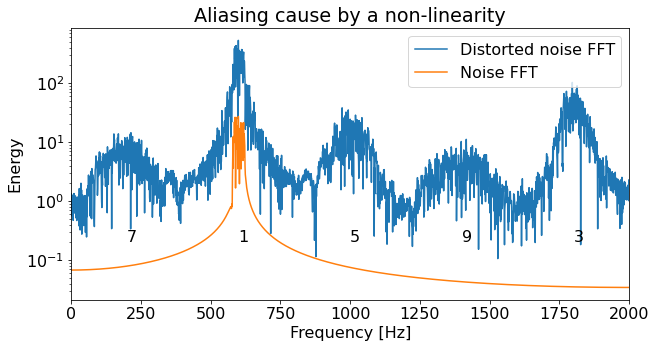

In [7]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot( np.abs( fft(noise_disto))[:], label="Distorted noise FFT")
ax.plot( np.abs( fft(noise))[:], label="Noise FFT")
plt.xlim(0, fs/2 ) 
#plt.ylim(-150)
plt.yscale("log")
ax.annotate('1', xy=(600, .2) )
ax.annotate('3', xy=(1800, .2) )
ax.annotate('5', xy=(1000, .2) )
ax.annotate('7', xy=(200, .2) )
ax.annotate('9', xy=(1400, .2) )
plt.title("Aliasing caused by a non-linearity")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Energy")
plt.legend(loc="best")
plt.show()

### 1.2. The solution: oversampling

Adding a low-pass filter after the non-linear function is useless as the exceding harmonics have already been mirrored back into the frequency spectrum. It is hence necessary to act directly during the nonlinear process. This is done by **oversampling** the signal before applying the nonlinearity, and by **undersampling** it after. By doing so, we increase the Nyquist frequency and hence have a lot more space "on the right" of the frequency plot for the harmonics to spead before they are bounced back to the left. When undersmapling, we reduce the Nyquist frequency back to its original value, and simply discard everything that is greater than it. Hence, most of the harmonics simply disappear and no more (noticeable) aliasing occurs!

Note that technically, it is impossible to completely get rid of aliasing since the harmonics spread up to infinity, however as their intensity quickly decreases, they become unnoticeable even with a relatively small oversampling factor. 

In [8]:
noise_oversample = oversample(noise)
noise_disto_oversample = nonLinearFunction(noise_oversample, 50)
noise_disto_downsample = undersample(noise_disto_oversample)

write_audio(noise_disto_downsample, "samples/noise_disto_downsample.wav", fs)

We can observe the influence of changing the oversampling rate on the final signal! The smaller the oversampling rate, the more wrap-up occurs, hence the stronger the aliasing!

In [9]:
@widgets.interact(oversampling=(1, 8, 1))
def update(oversampling=1):
    
    noise_oversample = oversample(noise, oversampling)
    noise_disto_oversample = nonLinearFunction(noise_oversample, 50)
    noise_disto_downsample = undersample(noise_disto_oversample, oversampling)

    fig, ax = plt.subplots(4, figsize=(10, 12))

    ax[0].set_title("Noise")
    ax[0].plot(np.abs( fft(noise))[:int(noise.size/2)])
    ax[1].set_title("Oversampled noise")
    ax[1].plot(np.abs( fft(noise_oversample))[:int(noise_oversample.size/2)])
    ax[2].set_title("Distorted oversampled noise")
    ax[2].plot(np.abs( fft(noise_disto_oversample))[:int(noise_disto_oversample.size/2)])
    ax[3].set_title("Distorted undersampled noise")
    ax[3].plot(np.abs( fft(noise_disto_downsample))[:int(noise_disto_downsample.size/2)])

    for axi in ax:
        axi.set_yscale("log")
        axi.axvline(fs/2, color="red", label="Nyquist")
        
    ax[3].set_xlabel("Frequency [Hz]")

    plt.subplots_adjust(hspace=0.7)
    plt.legend(loc="best")
    plt.show()

interactive(children=(IntSlider(value=1, description='oversampling', max=8, min=1), Output()), _dom_classes=('…

From now on, we are going to set the default oversampling factor to be 8.

### 1.3. Testing the static waveshaper on a guitar sample 

Let's finally try out our waveshaper on a guitar sample. The sound is not really good, and introduces a lot of greasyness!

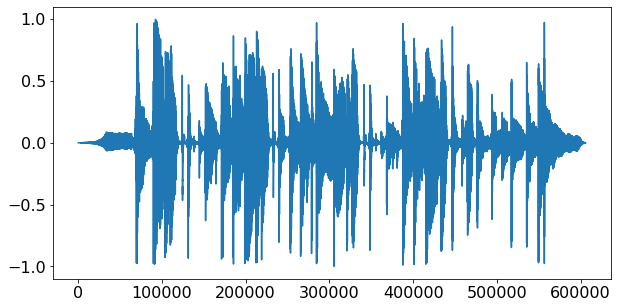

In [10]:
guitar_sample = open_audio('samples/guitar.wav')
Audio("samples/guitar.wav", autoplay=False)

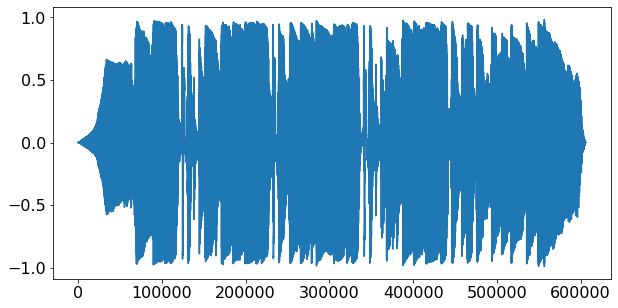

In [11]:
guitar_disto_waveshaper = oversample(guitar_sample)
guitar_disto_waveshaper = nonLinearFunction(guitar_disto_waveshaper, 20)
guitar_disto_waveshaper = undersample(guitar_disto_waveshaper)

plt.figure(figsize=figsize)
plt.plot(guitar_disto_waveshaper)

write_audio(guitar_disto_waveshaper, 'samples/guitar_disto_waveshaper.wav')

## 2. Wiener-Hammerstein model

One of the main issues with the static waveshaper is that it is static, i.e. it does not have memory and can't capture dynamics of a system over time. A lot of music devices, such as distortion or amplifiers, are known to have a dynamic behaviour and hence cannot be properly modelled with a static nonlinearity.

One proposed solution to this is the Wiener-Hammerstein model (a combination of the Wiener model and the Hammerstein model). Both models are gray-box and make the assumption that it is possible to approximate a **nonlinear dynamic system** by chaining several blocks in series, that process the dynamic behaviour and the nonlinearity indepedently. The Wiener-Hammerstein model is hence composed of a LTI filter moddeling a first dynamic behaviour, followed by a static nonlinearity, again followed by a second LTI filter.

<img src="https://i.imgur.com/ZLMBJrA.png" alt="Drawing" style="width: 70%;"/>

In the case of a guitar amplifier, the first LTI system can be seen as a modelling of a pre-amplifier, the nonlinearity as the overdrive of the amplifier, and the second LTI system as the cabinet (the speaker). One can hence record the impulse response of a speaker, and of a pre-amplifier, and convolve them with a guitar sound for the LTI systems, while using a static waveshaper for the middle nonlinearity. Let's implement this!

In [12]:
def wiener_hammerstein(x, alpha, IR_preamp, IR_cab):
    """
    Wiener-Hammerstein model for dynamic nonlinear systems.
    x: the input signal
    alpha: the intensity of the nonlinearity
    IR_preamp: the impulse response of the first LTI system
    IR_cab: the impulse response of the second LTI system
    return: the filtered normalized signal
    """
    # 1) LTI pre-amp IR
    x = np.convolve(x, IR_preamp)
    
    # 2) Static waveshaper
    x = oversample(x)
    x = nonLinearFunction(x, alpha)
    x = undersample(x)
    
    # 3) LTI cabinet IR
    x = np.convolve(x, IR_cab)
    
    return x / np.max(np.abs(x))

For the impulse responses, it is possible to find online datasets of many guitar amplifiers and cabinets IRs for free. For instance, [the website Overdriven.fr](https://overdriven.fr/overdriven/index.php/irdownloads/#Free_Guitar_Cabinet_Impulse_Responses) provides many free IRs corresponding to different amplifiers. Let's import an IR for the pre-amplifier and for the cabinet, and have a look at their shape and lenght. Both IRs have a duration of 50ms, which is enough for modelling an amplifier's behaviour.

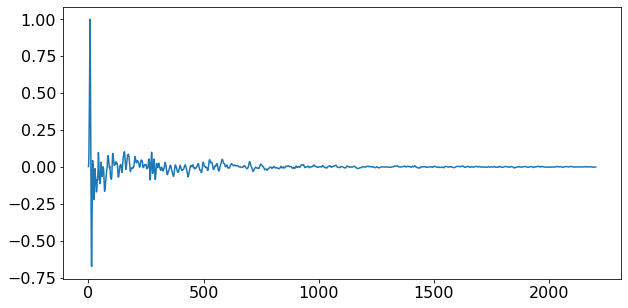

<string>:5: WavFileWarning: Chunk (non-data) not understood, skipping it.


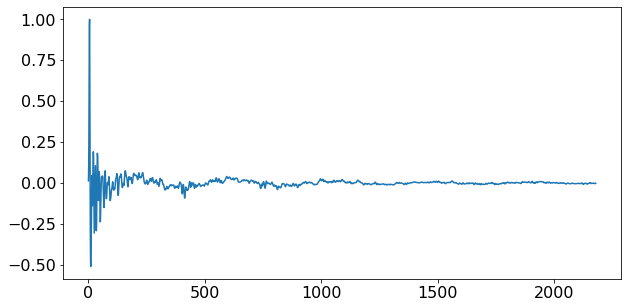

In [13]:
IR_preamp = open_audio("samples/IR_preamp.wav")
IR_cab = open_audio("samples/IR_cab.wav")

Let's now test our model using the same guitat sample as before. It sounds already much better!

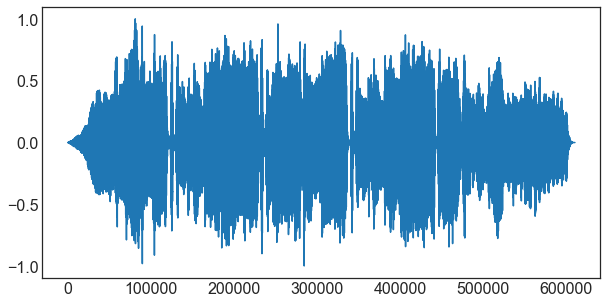

In [121]:
guitar_wh = wiener_hammerstein(guitar_sample, 15, IR_preamp, IR_cab)
    
plt.figure(figsize=figsize)
plt.plot(guitar_wh)
write_audio(guitar_wh, 'samples/guitar_wh.wav')

## 3. Identification using Volterrra kernels

TODO: fix this??

In [105]:
# Constants

p=5 # Maximum degree of the Volterra series
N=500 # test size

In [106]:
x_train = guitar_sample[200000:200000+N]
y_train = wiener_hammerstein(guitar_sample, 15, IR_preamp, IR_cab)[200000:200000+N]

### 3.1. Training the Volterra kernels

In [107]:
def a(n):
    return np.sqrt(1/math.factorial(n))

def kp(x1, x2):
    return np.sum( np.fromiter( (a(n)**2 * (x1*x2)**n for n in range(0,p) ), float) )

kp_vec = np.vectorize(kp, excluded=["x1"])

def kpVec(xnew, x):
    return (kp_vec(xnew, x)).T

In [108]:
# Global computation of the Gram Matrix K
Kp = np.zeros((N,N))
for i in range(0,N):
    for j in range(0,N):
        Kp[i,j] = kp(x_train[i], x_train[j])
        
KpInv = np.linalg.pinv(Kp)

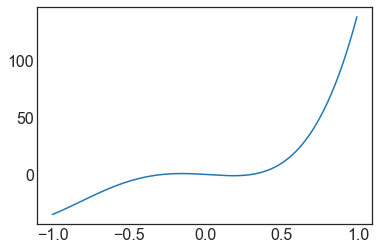

In [109]:
def volterraEstimation(newx, x, y):
    
    return y.T @ KpInv @ kpVec(newx, x)

plt.plot( np.arange(-1,1,0.01), [volterraEstimation(i, x_train, y_train) for i in np.arange(-1,1,0.01)])

In [110]:
def volterraFilter(x):
    y = np.zeros(x.size)
    
    for i in range(x.size):
        y[i] = volterraEstimation(x[i], x_train, y_train)
        
    return y

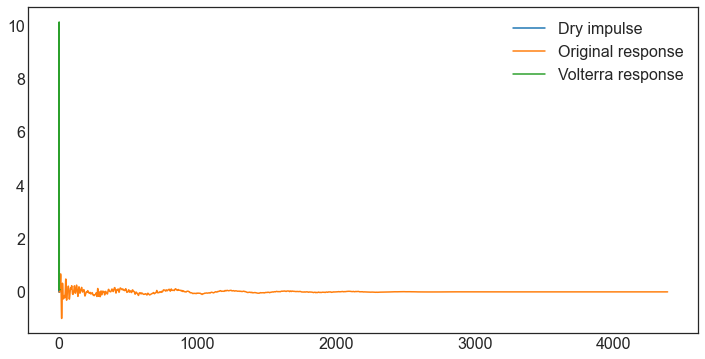

In [114]:
impulse = np.zeros(10)
impulse[2] = .5

originalImpulseResponse = wiener_hammerstein(impulse, 5, IR_preamp, IR_cab)
volterraImpulseResponse = volterraFilter(impulse)

plt.figure(figsize=(12,6))
plt.plot(impulse, label='Dry impulse')
plt.plot(originalImpulseResponse, label='Original response')
plt.plot(volterraImpulseResponse, label='Volterra response')
plt.legend(loc="best")
plt.show()

### 3.2. Test with actual guitar

In [ ]:
guitar_disto_volterra = volterraFilter(guitar_sample)

In [ ]:
write_audio(guitar_disto_volterra, "samples/guitar_disto_volterra.wav")